In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch

# Load the dataset
labels = np.load('/kaggle/input/seed-dataset/LabelsNoImage.npz')['arr_0']
subjects = np.load('/kaggle/input/seed-dataset/SubjectsNoImage.npz')['arr_0']
signals = np.load('/kaggle/input/seed-dataset/DatasetCaricatoNoImage.npz')['arr_0']

# Reshape signals and convert to DataFrame
signal = pd.DataFrame(signals.reshape(signals.shape[0], -1))
labels = pd.DataFrame(labels, columns=["label"])

# Concatenate and save
concatenated_df = pd.concat([signal, labels], axis=1)
concatenated_df.to_csv('seed.csv', index=False)

# View the first few rows
print(concatenated_df.head())

# Load the saved dataset
df = pd.read_csv('seed.csv')

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print(f"Unique labels: {df['label'].unique()}")

# Separate features and target
target_column = 'label'
X = df.drop(target_column, axis=1)
y = df[target_column]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)


           0          1          2          3          4          5  \
0  28.213411  27.665922  28.723648  26.018963  26.050634  29.088396   
1  28.217297  27.666159  28.733370  26.015753  26.050964  29.098383   
2  28.220051  27.667200  28.740765  26.012857  26.052341  29.105986   
3  28.221279  27.667473  28.745216  26.008944  26.052864  29.111124   
4  28.225702  27.671492  28.749952  26.007196  26.055405  29.116838   

           6          7          8          9  ...        301        302  \
0  27.429995  25.898748  25.887995  24.216867  ...  16.002846  16.420795   
1  27.439251  25.896072  25.886339  24.217155  ...  16.002274  16.420990   
2  27.446867  25.894821  25.885183  24.218273  ...  16.001606  16.420927   
3  27.452101  25.894768  25.885475  24.217356  ...  16.001341  16.420559   
4  27.457796  25.896587  25.889799  24.219389  ...  16.001589  16.420547   

         303        304        305        306        307        308  \
0  19.185806  18.497831  18.968849  18.681711

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 40728, Test size: 10182


In [5]:
import pandas as pd

# Assuming X_train and X_test are NumPy arrays
num_features = X.shape[1]  # Get the number of features
column_names = [f"feature_{i}" for i in range(num_features)]  # Generate generic feature names

# Convert X_train and X_test into DataFrames
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_test_df = pd.DataFrame(X_test, columns=column_names)

# Display the first few rows to verify
print(X_train_df.head())
print(X_test_df.head())


   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.358685   0.444394   0.396126   0.506177   0.465539   0.132175   
1   0.212850   0.284079   0.244220   0.570690   0.698584   0.251425   
2   0.260334   0.254006   0.320897   0.222342   0.421075   0.180642   
3   0.258579   0.256176   0.268882   0.268831   0.416309   0.200988   
4   0.341216   0.346172   0.342181   0.315885   0.413262   0.242689   

   feature_6  feature_7  feature_8  feature_9  ...  feature_300  feature_301  \
0   0.333059   0.384742   0.671730   0.644774  ...     0.151101     0.323671   
1   0.295779   0.328958   0.751470   0.724705  ...     0.101466     0.188109   
2   0.294299   0.343553   0.559618   0.472754  ...     0.157213     0.264138   
3   0.254407   0.256450   0.407758   0.304638  ...     0.125532     0.220463   
4   0.171755   0.268295   0.441461   0.475131  ...     0.225329     0.550806   

   feature_302  feature_303  feature_304  feature_305  feature_306  \
0     0.582217     0.1

In [6]:
import pandas as pd
from sklearn.feature_selection import f_regression

def calculate_mrmr_scores(X, y, K=None):
    if K is None:
        K = X.shape[1]

    # Compute F-statistics and initialize correlation matrix
    F = pd.Series(f_regression(X, y)[0], index=X.columns)
    corr = pd.DataFrame(0.00001, index=X.columns, columns=X.columns)

    # Initialize list of selected features and list of excluded features
    selected = []
    not_selected = X.columns.to_list()
    mrmr_scores = {}

    # Repeat K times
    for i in range(K):
        # Compute (absolute) correlations between the last selected feature and all the excluded features
        if i > 0:
            last_selected = selected[-1]
            corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(0.00001)

        # Compute FCQ score for all excluded features
        score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis=1).fillna(0.00001)

        # Find the best feature, add it to selected, and remove it from not_selected
        best = score.idxmax()
        selected.append(best)
        not_selected.remove(best)
        mrmr_scores[best] = score.max()

    # Compute scores for all features in the original order
    result_scores = [mrmr_scores[feature] for feature in X.columns]

    return result_scores

# Convert y_train to a 1D NumPy array
y_train_1d = y_train.detach().cpu().numpy().flatten()

# Calculate mRMR scores
mrmr_scores = calculate_mrmr_scores(X_train_df, y_train_1d)
mrmr_scores_df = pd.DataFrame({"Feature": X_train_df.columns, "mRMR Score": mrmr_scores})
print(mrmr_scores_df.sort_values(by="mRMR Score", ascending=False))


         Feature    mRMR Score
271  feature_271  1.276429e+09
94    feature_94  2.875823e+06
270  feature_270  2.681495e+04
209  feature_209  2.094284e+04
217  feature_217  1.707965e+04
..           ...           ...
90    feature_90  1.155704e+00
193  feature_193  3.005616e-01
214  feature_214  2.834414e-01
151  feature_151  2.792985e-01
48    feature_48  1.989265e-01

[310 rows x 2 columns]


In [7]:
K=350
top_features = mrmr_scores_df.nlargest(K, "mRMR Score")["Feature"].tolist()
print(f"Top {K} features: {top_features}")

Top 350 features: ['feature_271', 'feature_94', 'feature_270', 'feature_209', 'feature_217', 'feature_208', 'feature_76', 'feature_279', 'feature_262', 'feature_280', 'feature_200', 'feature_218', 'feature_297', 'feature_272', 'feature_85', 'feature_235', 'feature_210', 'feature_261', 'feature_288', 'feature_269', 'feature_278', 'feature_199', 'feature_226', 'feature_207', 'feature_86', 'feature_289', 'feature_304', 'feature_147', 'feature_242', 'feature_227', 'feature_296', 'feature_281', 'feature_84', 'feature_216', 'feature_298', 'feature_236', 'feature_268', 'feature_299', 'feature_273', 'feature_264', 'feature_93', 'feature_219', 'feature_75', 'feature_155', 'feature_237', 'feature_277', 'feature_302', 'feature_243', 'feature_28', 'feature_309', 'feature_83', 'feature_234', 'feature_308', 'feature_260', 'feature_246', 'feature_206', 'feature_202', 'feature_247', 'feature_103', 'feature_245', 'feature_23', 'feature_74', 'feature_198', 'feature_307', 'feature_146', 'feature_295', 'f

In [8]:
filtered_X_train = X_train_df[top_features]
filtered_X_test = X_test_df[top_features]

In [9]:
!pip install ReliefF
!pip install -U Py_FS==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ReliefF: filename=ReliefF-0.1.2-py3-none-any.whl size=6301 sha256=fafd28c795d2e4f055646685742ba6a7ea6c6514cbe727daf1955e843067c2cc
  Stored in directory: /root/.cache/pip/wheels/35/bc/0b/14a0227d4829b6b27f25de250213eb348b094d075be7604707
Successfully built ReliefF
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 851.1 kB/s eta 0:00:0000:0100:02



                          Iteration - 1

Crossover-Mutation phase starting....

Crossover no. 1
child 1 replaced with chromosome having id 30
child 2 replaced with chromosome having id 29

Crossover no. 2
child 1 replaced with chromosome having id 29
child 2 replaced with chromosome having id 28

Crossover no. 3
child 1 replaced with chromosome having id 29
child 2 replaced with chromosome having id 27

Crossover no. 4
child 1 replaced with chromosome having id 28
child 2 replaced with chromosome having id 26

Crossover no. 5
child 1 replaced with chromosome having id 30
child 2 replaced with chromosome having id 28

Number of agents: 30

------------- Best Agent ---------------
Fitness: 0.9690322580645161
Number of Features: 96
----------------------------------------

Chromosome 1 - Fitness: 0.9690322580645161, Number of Features: 96
Chromosome 2 - Fitness: 0.9690322580645161, Number of Features: 96
Chromosome 3 - Fitness: 0.9670967741935484, Number of Features: 102
Chromosome 4 - F

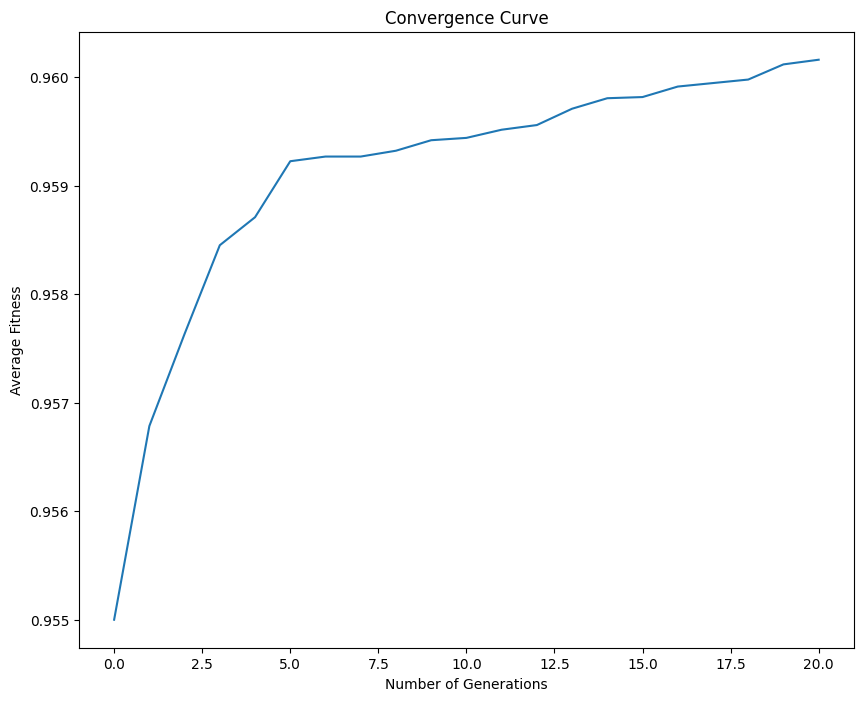


------------- Leader Agent ---------------
Fitness: 0.9690322580645161
Number of Features: 96
----------------------------------------



In [10]:
from Py_FS.wrapper.population_based.GA import GA as FS
algo = FS(num_agents=30, max_iter=20, train_data=filtered_X_train, train_label=y_train, save_conv_graph=True, default_mode=True)
results = algo.run()


In [11]:
mrmr_scores_df.to_csv('mrmr_scores.csv', index=False)

print("mRMR scores have been saved to 'mrmr_scores.csv'.")

mRMR scores have been saved to 'mrmr_scores.csv'.


In [12]:
results.solution.best_agent

array([1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 0.

In [13]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
selected_X_train = filtered_X_train.values[:, results.solution.best_agent.astype(bool)]
selected_X_test = filtered_X_test.values[:, results.solution.best_agent.astype(bool)]


# Standardize the feature data
scaler = StandardScaler()
selected_X_train = scaler.fit_transform(selected_X_train)
selected_X_test = scaler.transform(selected_X_test)

In [17]:
import torch
import numpy as np
import scipy.special

def fuzzy_gamma_feature_fusion(f1, f2, gamma_param=5.0):
    """
    Fuse three feature vectors using Gamma function–based weighting with batch support.
    
    Args:
        f1, f2, f3 (torch.Tensor): Tensors of shape (batch, feature_dim)
        gamma_param (float): Gamma parameter for weighting
        
    Returns:
        fused_feature (torch.Tensor): Fused tensor of shape (batch, feature_dim)
    """
    # Stack features along a new dimension: (batch, 3, feature_dim)
    features = torch.stack([f1, f2], dim=1)
    
    # Perform Min-Max normalization along the fusion (model) dimension for each sample
    # Here, normalization is done across the 3 models for each element of the feature vector.
    min_val = features.min(dim=1, keepdim=True)[0]
    max_val = features.max(dim=1, keepdim=True)[0]
    features_norm = (features - min_val) / (max_val - min_val + 1e-8)
    
    # Convert normalized features to NumPy for Gamma-based computation.
    # We detach to avoid gradient tracking.
    features_np = features_norm.detach().cpu().numpy()
    
    # Compute Gamma-based weights elementwise using:
    # weight = (x^(gamma_param - 1)) * exp(-x) / Gamma(gamma_param)
    weights_np = (features_np ** (gamma_param - 1)) * np.exp(-features_np) / scipy.special.gamma(gamma_param)
    
    # Convert weights back to a torch.Tensor on the same device as the input features.
    weights = torch.tensor(weights_np, dtype=torch.float32, device=features.device)
    
    # Normalize weights along the model dimension (axis 1) so that they sum to 1 per sample.
    weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-8)
    
    # Fuse the features using the computed weights (weighted sum along dimension 1)
    fused_feature = (weights * features).sum(dim=1)
    
    return fused_feature


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.special  # For Beta function

# Define the three models
class EnhancedEmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # Output shape: (batch, 64)


class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, out_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, out_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # h_n shape: (2, batch, hidden_size)
        h_n = torch.cat((h_n[0], h_n[1]), dim=-1)  # Concatenate forward & backward states
        return F.relu(self.fc(h_n))  # Output shape: (batch, 64)

# Beta Function for Feature Weighting
def beta_function(x, alpha=2, beta=5):
    """Computes Beta function-based weighting."""
    beta_val = scipy.special.beta(alpha, beta)
    return (x ** (alpha - 1)) * ((1 - x) ** (beta - 1)) / beta_val

def fuzzy_beta_feature_fusion(f1, f2, alpha=2, beta=1):
    """
    Fuse three feature vectors using Beta function-based weighting.
    Inputs:
        f1, f2, f3: Feature tensors (batch, 64)
    Returns:
        fused_feature: Tensor (batch, 64)
    """
    # Stack features along a new dimension: (batch, 3, 64)
    features = torch.stack([f1, f2], dim=1)

    # Min-Max Normalization across the feature dimension (batch-wise)
    min_val = features.min(dim=1, keepdim=True)[0]
    max_val = features.max(dim=1, keepdim=True)[0]
    features = (features - min_val) / (max_val - min_val + 1e-8)

    # Convert tensor to numpy safely using .detach()
    features_np = features.detach().cpu().numpy()

    # Compute Beta-based weights
    beta_values_np = beta_function(features_np, alpha, beta)

    # Convert weights back to tensor
    beta_values = torch.tensor(beta_values_np, dtype=torch.float32, device=features.device)

    # Normalize weights (batch-wise)
    weights = beta_values / beta_values.sum(dim=1, keepdim=True)

    # Compute weighted sum for fusion
    fused_feature = (weights * features).sum(dim=1)

    return fused_feature  # Output shape: (batch, 64)

# Final Classifier Model
class BetaFusedClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, out_dim):
        super().__init__()
        self.enhanced_emotion = EnhancedEmotionClassifier(input_size, hidden_size, 64)
        # self.transformer = TransformerClassifier(input_size, 64)
        self.bilstm = BiLSTMClassifier(input_size, hidden_size, 64)

        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim)  # 3-class classification
        )

    def forward(self, x):
        f1 = self.enhanced_emotion(x)  # (batch, 64)
        # f2 = self.transformer(x)  # (batch, 64)
        f2 = self.bilstm(x.unsqueeze(1))  # (batch, 64)

        fused_feature = fuzzy_gamma_feature_fusion(f1, f2)  # (batch, 64)
        return self.classifier(fused_feature)  # (batch, 3)

# Example Usage
batch_size = 16
input_size = selected_X_train.shape[1]
hidden_size = 64
out_dim = 3  # 3-class classification

model = BetaFusedClassifier(input_size, hidden_size, out_dim)

# Dummy Batch Input
x = torch.rand(batch_size, input_size)

# Forward Pass
output = model(x)
print(output.shape)  # (batch, 3)


torch.Size([16, 3])


In [19]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(selected_X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Convert to NumPy array first
X_test_tensor = torch.tensor(selected_X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Convert to NumPy array first

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<ipython-input-19-332a62162ca6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Convert to NumPy array first
<ipython-input-19-332a62162ca6>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Convert to NumPy array first


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy.special  # For Beta function
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Function with Best Model Saving
def train_model(model, optimizer, scheduler, train_loader, val_loader, num_epochs, model_path="best_model.pth"):
    model.to(device)
    best_val_loss = float("inf")

    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        total_loss = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

        # Validate after each epoch
        val_loss = evaluate_model(model, val_loader, compute_loss=True)

        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved at epoch {epoch+1}")

        scheduler.step(val_loss)  # Reduce LR if validation loss plateaus

# Evaluation Function
def evaluate_model(model, val_loader, compute_loss=False):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if compute_loss:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    
    print(f"Validation - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return total_loss / len(val_loader) if compute_loss else (acc, precision, recall, f1)

# Initialize model, optimizer, and scheduler
batch_size = 32
input_size = selected_X_train.shape[1]
hidden_size = 8
out_dim = 3  # 3-class classification

model = BetaFusedClassifier(input_size, hidden_size, out_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the model and save the best version
num_epochs = 10
train_model(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

# Load the best model before final evaluation
model.load_state_dict(torch.load("best_model.pth"))
print("✅ Loaded best model for final evaluation.")

# Evaluate the best model
evaluate_model(model, test_loader)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.1125


Training:  10%|█         | 1/10 [00:03<00:32,  3.62s/it]

Validation - Accuracy: 0.9904, Precision: 0.9903, Recall: 0.9902, F1-score: 0.9902
✅ Best model saved at epoch 1
Epoch 2/10 - Train Loss: 0.0257


Training:  20%|██        | 2/10 [00:06<00:25,  3.23s/it]

Validation - Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9969, F1-score: 0.9969
✅ Best model saved at epoch 2
Epoch 3/10 - Train Loss: 0.0025


Training:  30%|███       | 3/10 [00:09<00:21,  3.11s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 3
Epoch 4/10 - Train Loss: 0.0000


Training:  40%|████      | 4/10 [00:12<00:18,  3.08s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 4
Epoch 5/10 - Train Loss: 0.0000


Training:  50%|█████     | 5/10 [00:15<00:15,  3.10s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 5
Epoch 6/10 - Train Loss: 0.0000


Training:  60%|██████    | 6/10 [00:18<00:12,  3.03s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 6
Epoch 7/10 - Train Loss: 0.0000


Training:  70%|███████   | 7/10 [00:21<00:09,  3.00s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 7
Epoch 8/10 - Train Loss: 0.0000


Training:  80%|████████  | 8/10 [00:24<00:05,  2.98s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 8
Epoch 9/10 - Train Loss: 0.0000


Training:  90%|█████████ | 9/10 [00:27<00:02,  2.95s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 9
Epoch 10/10 - Train Loss: 0.0000


Training: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]

Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
✅ Best model saved at epoch 10
✅ Loaded best model for final evaluation.



<ipython-input-20-4b79ce68b0f5>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


(1.0, 1.0, 1.0, 1.0)